## Preprocessing of imaging data: Volume vs. projection to single plane

In [1]:
from ScanImageTiffReader import ScanImageTiffReader
import json
from matplotlib import pyplot as plt
import matplotlib.colors as colors
import numpy as np

#from sys import path
from os.path import sep, exists
from os import mkdir, makedirs, getcwd

import napari
import xarray as xr
import pandas as pd

In [2]:
%gui qt5
%config Completer.use_jedi = False  #magic to fix autocomplete issue

In [3]:
from fly2p.viz.viz import myAxisTheme
from fly2p.preproc.scanImageUtils import getSIbasicMetadata, getSIMetadict, loadvolume
import fly2p.preproc.imgPreproc as imp

### (1) Load, parse metadata and generate data object
#### Set paths to data files and plot directory

In [4]:
rootDir = '../../../../data_unityvr'
subdir = 'RFmap'
dataDir = sep.join([rootDir, 'raw',subdir,'56H10_x_7f/BU/f01'])
rawTiff = '56H10-x-7f_f01_3-5d_BU_RFmapTest_brightSpot_00001.tif'
plotDir = sep.join([rootDir, 'plot', sep.join(dataDir.split(sep)[-4:])])
preprocDir = sep.join([rootDir, 'preproc', sep.join(dataDir.split(sep)[-4:])])

genotype = '-'.join(rawTiff.split('_')[0:3])
[flyID, age, region] = rawTiff.split('_')[1:4]
condition = rawTiff.split('_')[-2]
trial = "trial"+rawTiff.split('_')[-1][3:-4]
print('Genotype: {}, Imaging region: {}, Fly id: {}\nCondition: {}, Trial: {}'.format(
    genotype, region, flyID, condition, trial))

Genotype: 56H10-x-7f-f01-3-5d, Imaging region: BU, Fly id: f01
Condition: brightSpot, Trial: trial01


In [5]:
# Generate directory where to save plots
saveDir = sep.join([plotDir]) #condition
if not exists(saveDir):
    makedirs(saveDir)
print(saveDir)

ppsaveDir = sep.join([preprocDir])
if not exists(ppsaveDir):
    makedirs(ppsaveDir)
print(ppsaveDir)

../../../../data_unityvr/plot/RFmap/56H10_x_7f/BU/f01
../../../../data_unityvr/preproc/RFmap/56H10_x_7f/BU/f01


#### Load data and perform motion correction
Extract relevant information from header, read and reshape image tiff stack

In [6]:
mytiffreader = ScanImageTiffReader(sep.join([dataDir, rawTiff]))
basicMetadat = getSIbasicMetadata(mytiffreader.metadata())
basicMetadat["CaCh"] = 0 # give channel identity
SImetadict = getSIMetadict(mytiffreader.metadata())

stack = loadvolume(mytiffreader, basicMetadat, selectCaChan=True)
imgStack = imp.stack2xarray(stack, basicMetadat)

SI.VERSION_COMMIT = '3baa4b74bec9938bfd4c7403bddbe78f2a0ccd93'
SI.VERSION_MAJOR = 2021
SI.VERSION_MINOR = 0
SI.VERSION_UPDATE = 0


In [7]:
# To debug only: cut stack in half
#imgStack = imgStack[1000:2000,:,:]

Check if reference image is good: It should not be to biased by transient activity peaks.

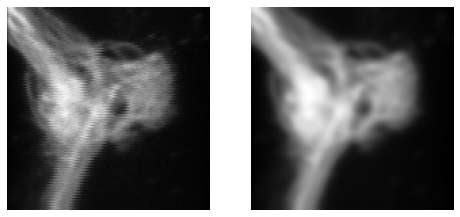

In [8]:
# Set reference image
stackMP = np.max(imgStack, axis=1) # max projection over volume

numRefImg = 600
locRefImg = round(stackMP['volumes [s]'].size/3)

# Generate reference image
refImg = np.mean(stackMP[locRefImg:locRefImg+numRefImg,:,:],axis=0)

from scipy.ndimage.filters import gaussian_filter
refImgFilt = gaussian_filter(refImg, sigma=2)

fig, axs = plt.subplots(1,2,figsize=(8,4))
axs[0].imshow(refImg,cmap='Greys_r', origin='lower'); axs[0].axis('off');
axs[1].imshow(refImgFilt,cmap='Greys_r', origin='lower'); axs[1].axis('off');

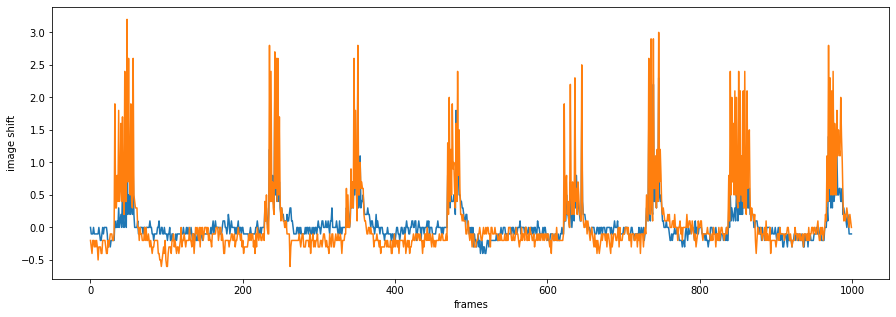

In [9]:
# If there are unreasonable shifts (e.g. because of the calcium EB bump being moved to the same spot
# although it is in different positions) select "doFilter=True".
# try larger sigma (last function argument) for BU imaging
shift = imp.computeMotionShift(stackMP, refImg, 10, 2, doFilter=False, stdFactor=4, showShiftFig=True)

Apply estimated motion to 4d stack. We assume here that all planes in a volume at a given time moved together

In [10]:
stack4dMC = imp.applyShiftTo4Dstack(imgStack, shift)

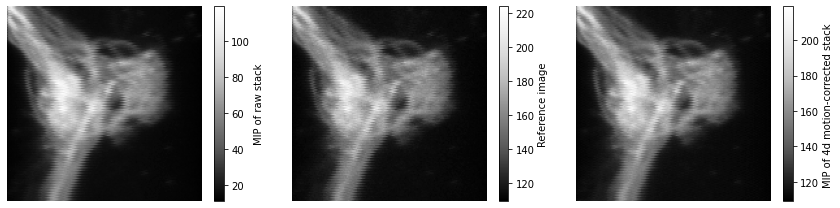

In [11]:
fig, axs = plt.subplots(1,3,figsize=(12,3))
cb = axs[0].imshow(stack.max(axis=1).mean(axis=0),cmap='Greys_r', origin='lower')
plt.colorbar(cb, ax=axs[0], label='MIP of raw stack')
axs[0].axis('off');
cb = axs[1].imshow(refImg,cmap='Greys_r', origin='lower')
plt.colorbar(cb, ax=axs[1], label='Reference image')
axs[1].axis('off');
cb = axs[2].imshow(stack4dMC.max(axis=1).mean(axis=0),cmap='Greys_r', origin='lower')
plt.colorbar(cb, ax=axs[2], label='MIP of 4d motion-corrected stack ')
axs[2].axis('off');
fig.tight_layout()

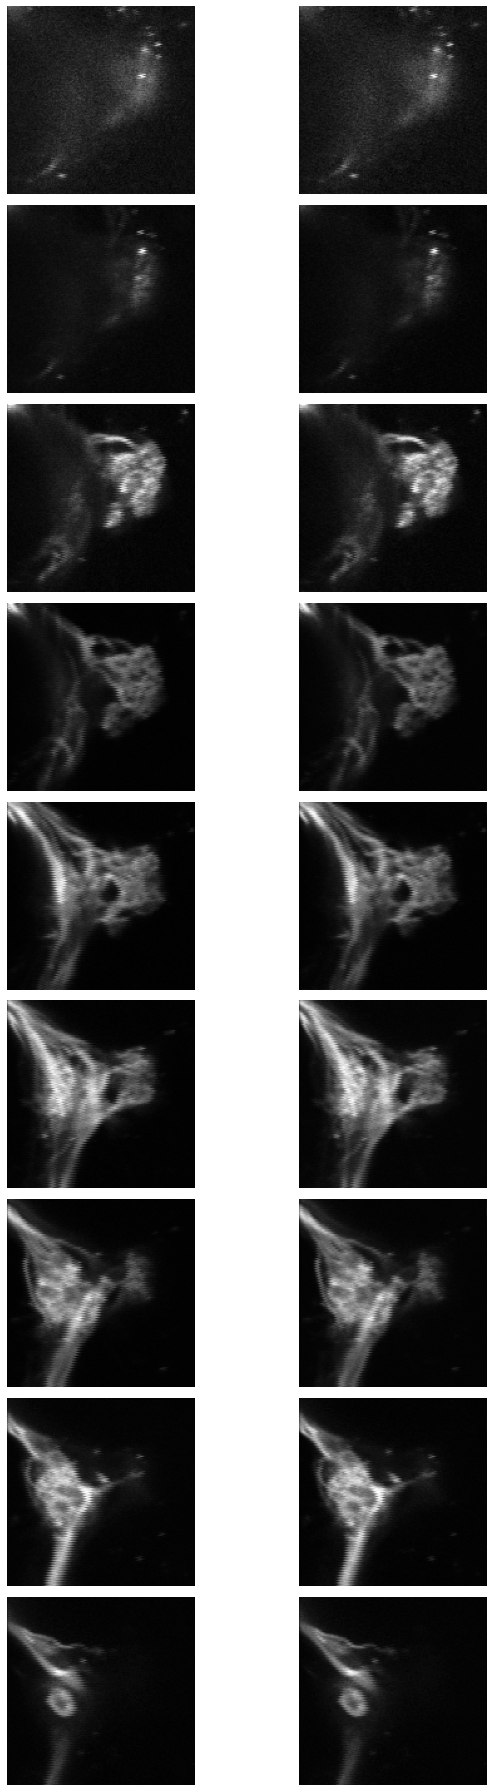

In [12]:
fig, ax = plt.subplots(stack4dMC["planes [µm]"].size,2, figsize=(10, 25))
for i in range(stack4dMC["planes [µm]"].size):
    ax[i,0].imshow(imgStack[:,i,:,:].mean(axis=0),cmap='Greys_r',origin='lower')
    ax[i,1].imshow(stack4dMC[:,i,:,:].mean(axis=0),cmap='Greys_r',origin='lower')
    ax[i,0].axis('off')
    ax[i,1].axis('off');
fig.tight_layout()
fig.savefig(saveDir+sep+'_'.join(['meanSignal_beforeAfterMC',genotype, region, flyID, condition, trial])+'.pdf')

In [18]:
viewerdff1 = napari.view_image(stack4dMC)

/Users/haberkernh/anaconda3/envs/fly2p/lib/python3.9/site-packages/napari/_vispy/vispy_camera.py:109: RuntimeWarning: divide by zero encountered in true_divide
  zoom = np.min(canvas_size / scale)


### Perform correlation analysis to get ROIs

#### (1) Compute DFF

In [14]:
## Settings
# settings for Savitzky-Golay filter (default: 3rd order, 7 frames)
order = 3
window = 7

# Currently F_0 is estimated for each pixel on the whole time series (ok, if time series is short)
baseLinePercent = 10
offset = 0.0001

processing 4d stack


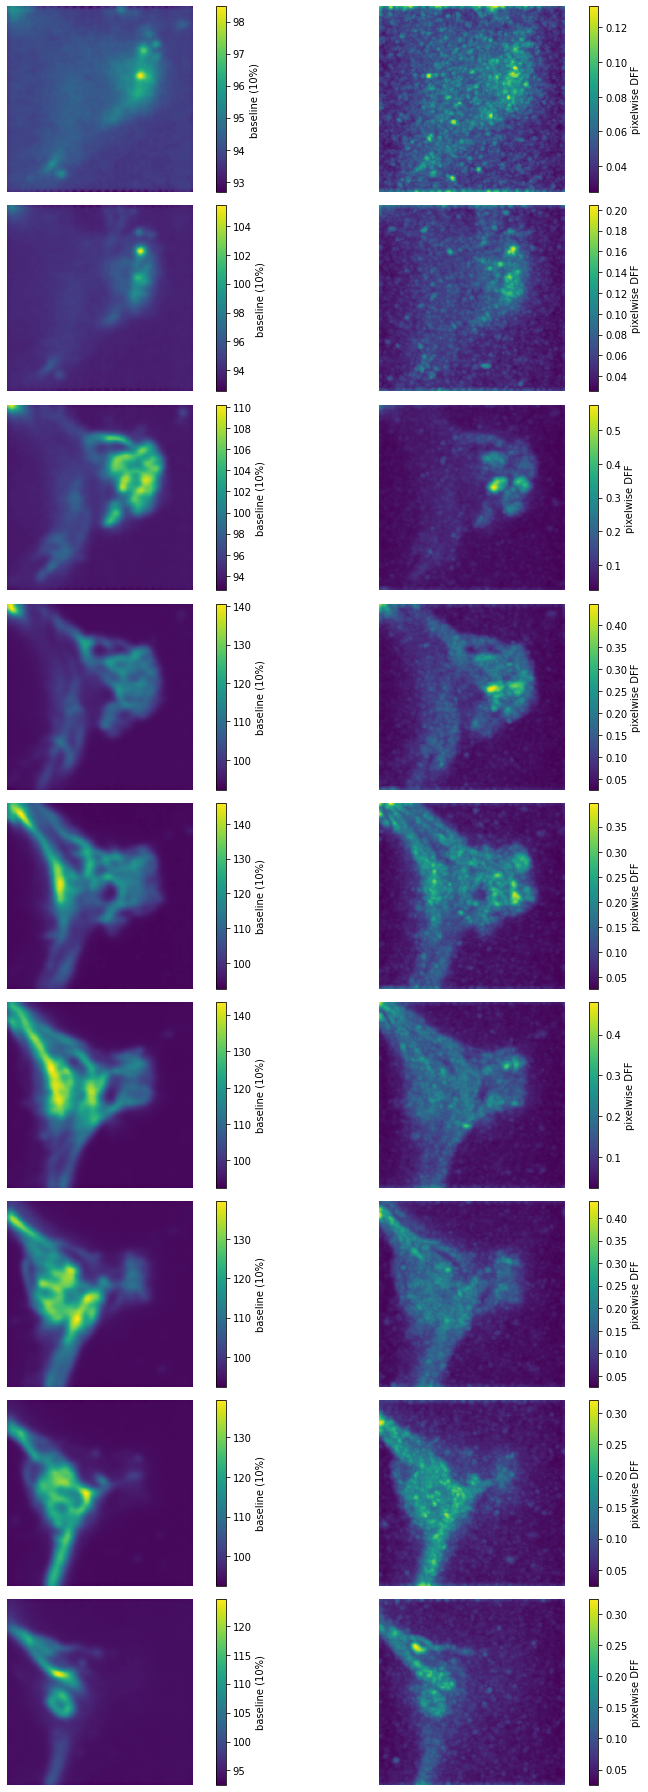

In [15]:
dffStack4d, stackF0vol = imp.computeDFF(stack4dMC, order, window, baseLinePercent, offset)
fig, ax = plt.subplots(stack4dMC["planes [µm]"].size,2,figsize=(12,25))
for i in range(stack4dMC["planes [µm]"].size):
    cb = ax[i,0].imshow(stackF0vol[i,:,:],cmap='viridis',origin='lower')#, vmin=0, vmax=10)
    plt.colorbar(cb, ax=ax[i,0], label='baseline ({}%)'.format(baseLinePercent))
    ax[i,0].axis('off')
    
    cb = ax[i,1].imshow(np.max(dffStack4d[:,i,:,:],axis=0),cmap='viridis',origin='lower')#, vmin=0, vmax=10)
    plt.colorbar(cb, ax=ax[i,1], label='pixelwise DFF')
    ax[i,1].axis('off')
    
fig.tight_layout()
fig.savefig(saveDir+sep+'_'.join(['DFFperPlane_beforeAfterMC',genotype, region, flyID, condition, trial])+'.pdf')

In [16]:
dff4dXarray = imp.stack2xarray(dffStack4d, basicMetadat, data4D = True)
F0volXarray = imp.refStack2xarray(stackF0vol, basicMetadat, data4D = True)

In [17]:
viewerdff1 = napari.view_image(dff4dXarray)

/Users/haberkernh/anaconda3/envs/fly2p/lib/python3.9/site-packages/napari/_vispy/vispy_camera.py:109: RuntimeWarning: divide by zero encountered in true_divide
  zoom = np.min(canvas_size / scale)


In [18]:
savearrays = False
if savearrays:
    if not exists(sep.join([preprocDir, condition])):
        makedirs(sep.join([preprocDir, condition]))

    dff4dXarray.to_netcdf(sep.join([preprocDir, condition,'DFF4d.nc']), mode='w')
    np.save(sep.join([preprocDir, condition,'DFF4d.npy']),dffStack4d)
    F0volXarray.to_netcdf(sep.join([preprocDir, condition,'F0vol.nc']), mode='w')
    np.save(sep.join([preprocDir, condition,'F0vol.npy']),stackF0vol)
    np.save(sep.join([preprocDir, condition,'stack4dMC.npy']),stack4dMC)

#### (2) Define regions on which to perform clustering

In [19]:
#use gaussian filtering and std to separate background and foreground
from scipy.ndimage import gaussian_filter
dffFitSigma = 1

dffStackGF = gaussian_filter(dffStack4d, (0,0,dffFitSigma,dffFitSigma))
#viewerGF = napari.view_image(dffStackGF)

In [20]:
# make a mask of relevant pixels based on the standard deviation of the time series
stdStack = np.std(dffStackGF, axis=0)
stdMask = stdStack >= np.percentile(stdStack, 70)

#viewerMask = napari.view_image(stdMask)

Mark the area that should be considered with the napari labeling tool in a layer named "mask".

In [22]:
refStack = stack4dMC[0,:,:,:]
for i in range(stack4dMC["planes [µm]"].size):
    refStack[i,:,:] = stack4dMC[:,i,:,:].mean(axis=0)
    
viewer3D = napari.view_image(refStack)

/Users/haberkernh/anaconda3/envs/fly2p/lib/python3.9/site-packages/napari/_vispy/vispy_camera.py:109: RuntimeWarning: divide by zero encountered in true_divide
  zoom = np.min(canvas_size / scale)


In [24]:
manMask3D = viewer3D.layers["mask"]
dffMask = np.logical_and(stdMask, manMask3D.data>0)

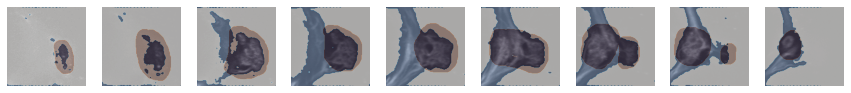

In [25]:
fig, ax = plt.subplots(1,stack4dMC["planes [µm]"].size, figsize=(15,4))
for i in range(stack4dMC["planes [µm]"].size):
    ax[i].imshow(refStack[i,:,:],cmap='Greys_r',origin='lower', alpha=0.9)  
    ax[i].axis('off');
    ax[i].imshow(manMask3D.data[i,:,:], cmap='Oranges', alpha=0.4)
    ax[i].imshow(stdMask[i,:,:], cmap='Blues', alpha=0.4)
    
fig.savefig(saveDir+sep+'_'.join(['mask3D',genotype, region, flyID, condition, trial])+'.pdf')

In [26]:
viewerMask = napari.view_image(dffMask)

/Users/haberkernh/anaconda3/envs/fly2p/lib/python3.9/site-packages/napari/_vispy/vispy_camera.py:109: RuntimeWarning: divide by zero encountered in true_divide
  zoom = np.min(canvas_size / scale)


#### Draw manual ROIs as a comparison point

In [28]:
# Manually draw ROIs as a ground truth

refStack = dffStackGF[0,:,:,:].copy() #stack4dMC[0,:,:,:]
for i in range(stack4dMC["planes [µm]"].size):
    refStack[i,:,:] = dffStackGF[:,i,:,:].mean(axis=0) #stack4dMC
refStack[~dffMask] = 0
viewer3D = napari.view_image(refStack)

/Users/haberkernh/anaconda3/envs/fly2p/lib/python3.9/site-packages/napari/_vispy/vispy_camera.py:109: RuntimeWarning: divide by zero encountered in true_divide
  zoom = np.min(canvas_size / scale)


28


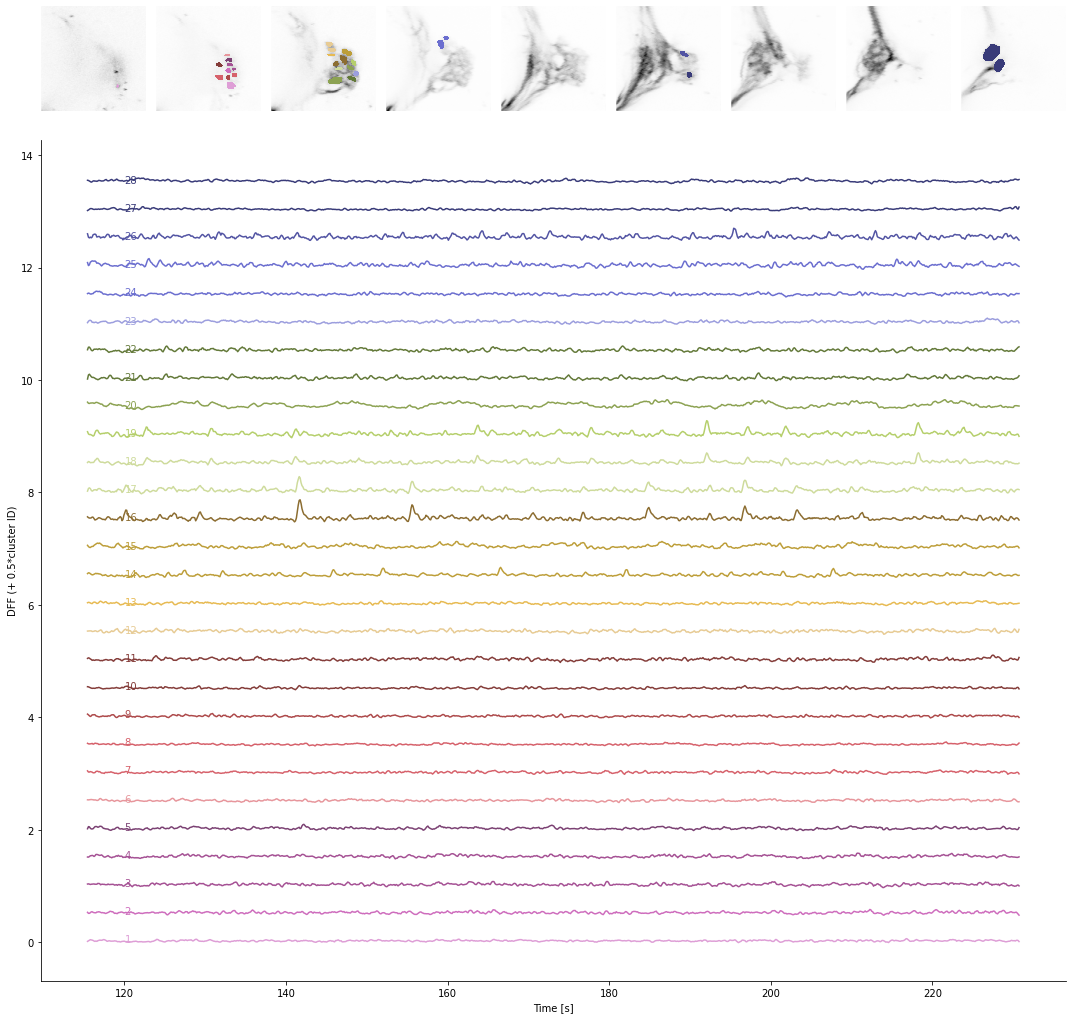

In [31]:
#pull out manusal rois and plot
roiMasks = viewer3D.layers["rois"]
# tmp = napari.view_image(roiMasks.data)

nclst_4d = np.max(roiMasks.data)
print(nclst_4d)

myClstMap = 'tab20b_r'
cNorm  = colors.Normalize(vmin=0, vmax=nclst_4d)
clstCMap = plt.cm.ScalarMappable(norm=cNorm,cmap=myClstMap)

time = stack4dMC.coords['volumes [s]'].values

roiPos = roiMasks.data.copy()
fig = plt.figure(figsize=(15,15))
#import matplotlib.gridspec as gridspec
gs  = fig.add_gridspec(2,stack4dMC["planes [µm]"].size, height_ratios=[1,4])

for p in range(stack4dMC["planes [µm]"].size):
    ax = fig.add_subplot(gs[p])
    ax.imshow(stack4dMC[:,p,:,:].mean(axis=0),cmap='Greys',origin='lower')  
    #ax.imshow(roiPos[p,:,:],cmap=myClstMap,origin='upper',vmin=0, vmax=nclst_4d)
    for i in range(nclst_4d):
        myclustmap = (roiPos[p,:,:]==(i+1)).astype('float')
        myclustmap[myclustmap == 0] = np.nan
        ax.imshow(myclustmap*(i+1),origin='upper',cmap=myClstMap, vmin=0, vmax=nclst_4d-1)
        ax.axis('off')
    
ax = fig.add_subplot(gs[1,:])
for i in range(nclst_4d):
    ax.plot(time, dffStackGF[:,roiMasks.data == (i+1)].mean(axis=1)+i*0.5, color=clstCMap.to_rgba(i+1))
    ax.text(120,i*.5,str(i+1),color=clstCMap.to_rgba(i+1))
ax.set_xlabel('Time [s]')
ax.set_ylabel('DFF (+ 0.5*cluster ID)')
#ax.set_ylim(0, 1+nclst_4d)
myAxisTheme(ax)
fig.tight_layout()

fig.savefig(saveDir+sep+'_'.join(['manROIs',genotype, region, flyID, condition, trial])+'.pdf')

#### (3) Perform clustering on pixels in mask

In [33]:
toClust = dffStackGF[:,dffMask] #dffStack4dMC[:,dffMask]
time = stack4dMC.coords['volumes [s]'].values

In [44]:
# Settings
from sklearn.cluster import KMeans

nclst_4d = 15

In [45]:
kmeans_4d = KMeans(n_clusters=nclst_4d)
kmeans_4d.fit(toClust.T)

KMeans(n_clusters=15)

In [46]:
kmlabs_4d = kmeans_4d.predict(toClust.T)
centroids_4d = kmeans_4d.cluster_centers_

In [47]:
myClstMap = 'tab20b_r'
cNorm  = colors.Normalize(vmin=1, vmax=nclst_4d)
clstCMap = plt.cm.ScalarMappable(norm=cNorm,cmap=myClstMap)

In [48]:
kmlabsImg_3dNoNan = -1*np.ones(dffMask.data.shape)
kmlabsImg_3dNoNan[dffMask] = kmlabs_4d

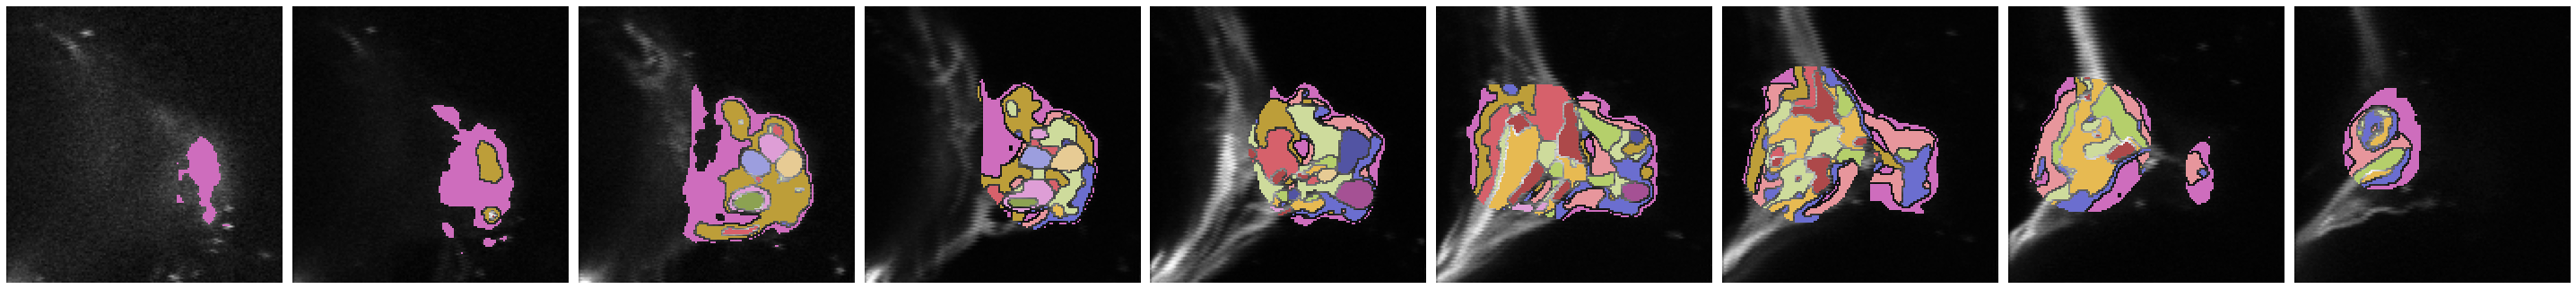

In [49]:
fig = plt.figure(figsize=(40,7))
gs  = fig.add_gridspec(1,stack4dMC["planes [µm]"].size)
for p in range(stack4dMC["planes [µm]"].size):
    ax = fig.add_subplot(gs[0,p])
    #ax.imshow(kmlabsImg_3d[p,:,:],cmap=myClstMap,origin='upper',vmin=0, vmax=nclst_4d)
    #ax.axis('off')
    ax.imshow(stack4dMC[:,p,:,:].mean(axis=0),cmap='Greys_r',origin='lower')  
    #ax.imshow(roiPos[p,:,:],cmap=myClstMap,origin='upper',vmin=0, vmax=nclst_4d)
    for i in range(nclst_4d):
        myclustmap = (kmlabsImg_3dNoNan[p,:,:]==(i)).astype('float')
        myclustmap[myclustmap == 0] = np.nan
        ax.imshow(myclustmap*(i),origin='upper',cmap=myClstMap, vmin=0, vmax=nclst_4d)
        ax.axis('off')
fig.tight_layout()
fig.savefig(saveDir+sep+'_'.join(['ROIcluster3D_map_kn{}'.format(nclst_4d),genotype, region, flyID, condition, trial])+'.pdf')

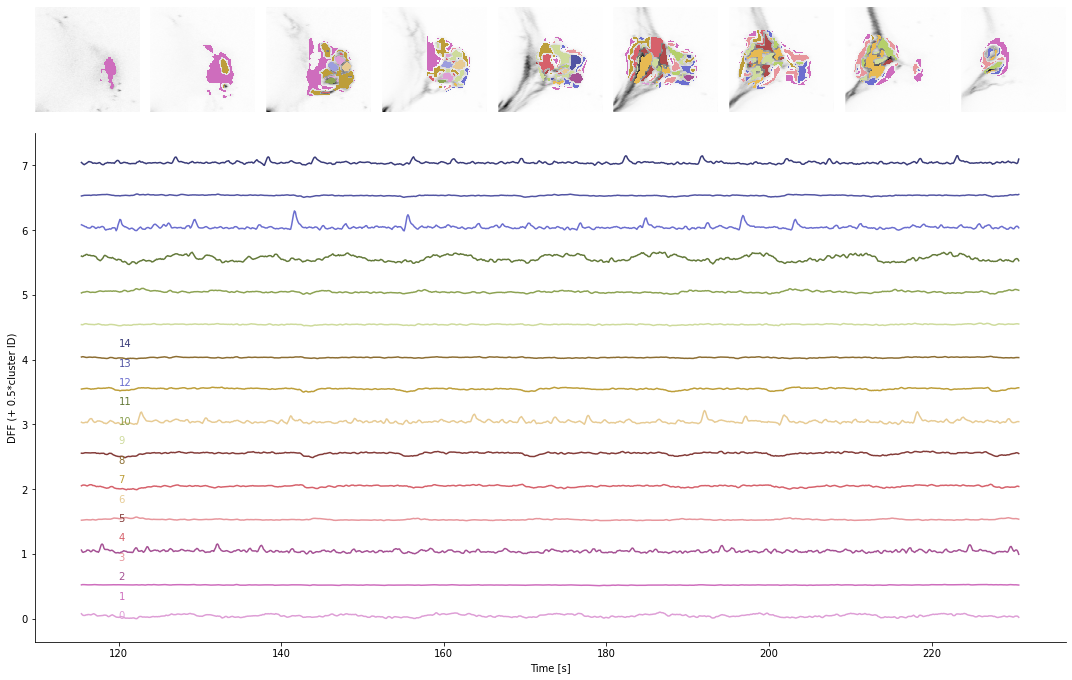

In [50]:
kmlabsImg_3d = np.nan*np.ones(dffMask.data.shape)

kmlabsImg_3d[dffMask] = kmlabs_4d

fig = plt.figure(figsize=(15,10))
#import matplotlib.gridspec as gridspec
gs  = fig.add_gridspec(2,stack4dMC["planes [µm]"].size, height_ratios=[1,3])

for p in range(stack4dMC["planes [µm]"].size):
    ax = fig.add_subplot(gs[0,p])
    #ax.imshow(kmlabsImg_3d[p,:,:],cmap=myClstMap,origin='upper',vmin=0, vmax=nclst_4d)
    #ax.axis('off')
    ax.imshow(stack4dMC[:,p,:,:].mean(axis=0),cmap='Greys',origin='lower')  
    #ax.imshow(roiPos[p,:,:],cmap=myClstMap,origin='upper',vmin=0, vmax=nclst_4d)
    for i in range(nclst_4d):
        myclustmap = (kmlabsImg_3dNoNan[p,:,:]==(i)).astype('float')
        myclustmap[myclustmap == 0] = np.nan
        ax.imshow(myclustmap*(i),origin='upper',cmap=myClstMap, vmin=0, vmax=nclst_4d)
        ax.axis('off')
        
ax = fig.add_subplot(gs[1,:])
for i in range(nclst_4d):
    ax.plot(time,centroids_4d[i]+i*0.5, color=clstCMap.to_rgba(i+1))
    ax.text(120,i*0.3,str(i),color=clstCMap.to_rgba(i+1))
ax.set_xlabel('Time [s]')
ax.set_ylabel('DFF (+ 0.5*cluster ID)')
#ax.set_ylim(0, 1+nclst_4d)
myAxisTheme(ax)
fig.tight_layout()
fig.savefig(saveDir+sep+'_'.join(['ROIcluster3D_DFFtraces_kn{}'.format(nclst_4d),genotype, region, flyID, condition, trial])+'.pdf')

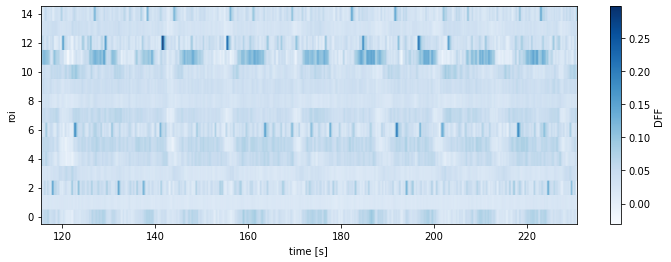

In [51]:
#centroidPerm = np.argsort(yPosClust)#
centroids2Plot = centroids_4d#[centroidPerm,:]

fig, axs = plt.subplots(1,1,figsize=(12,4))

c = axs.pcolor(time,np.arange(0,nclst_4d),centroids2Plot,cmap='Blues', edgecolors='face',shading='auto')
fig.colorbar(c, ax=axs, label="DFF")
axs.set_xlabel('time [s]')
axs.set_ylabel('roi')
fig.savefig(saveDir+sep+'_'.join(['ROIcluster3D_kn{}_DFF'.format(nclst_4d),genotype, region, flyID, condition,  trial])+'.pdf')

In [52]:
viwerlabs = napari.view_image(kmlabsImg_3dNoNan)

/Users/haberkernh/anaconda3/envs/fly2p/lib/python3.9/site-packages/napari/_vispy/vispy_camera.py:109: RuntimeWarning: divide by zero encountered in true_divide
  zoom = np.min(canvas_size / scale)


/var/folders/fv/tc13bbx50b93h1m7l9v16z5svg9h4d/T/ipykernel_31195/4121793835.py:18: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()


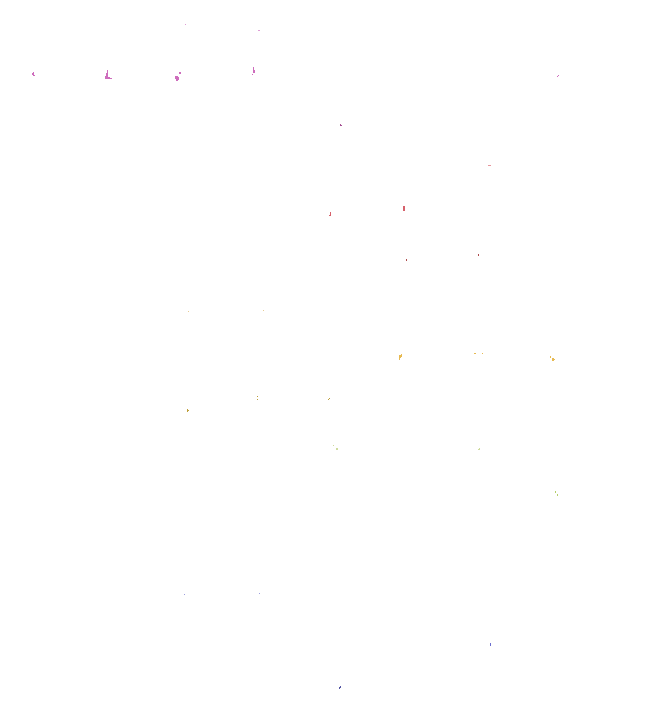

In [53]:
kmlabsImg_3d = np.nan*np.ones(dffMask.data.shape)

kmlabsImg_3d[dffMask] = kmlabs_4d
step = 1
fig = plt.figure(constrained_layout=True,figsize=(10,10))
#import matplotlib.gridspec as gridspec
gs  = fig.add_gridspec(nclst_4d,stack4dMC["planes [µm]"].size)

for l, k in enumerate(range(0,nclst_4d,step)):
    for p in range(stack4dMC["planes [µm]"].size):
        ax = fig.add_subplot(gs[l,p])
        for i in range(step):
            myclustmap = (kmlabsImg_3d[p,:,:] == (k + i)).astype('float')
            myclustmap[myclustmap == 0] = np.nan
            ax.imshow(myclustmap*(k + i),origin='upper',cmap=myClstMap, vmin=0, vmax=nclst_4d)
        if p==0: ax.set_ylabel('roi{}'.format(k+i))
        ax.axis('off')
fig.tight_layout()
fig.savefig(saveDir+sep+'_'.join(['ROIcluster3DMap_kn{}'.format(nclst_4d),genotype, region, flyID, condition, trial])+'.pdf')

#### Generate data object and save to disk

In [54]:
#backgroundROI = 1
otherROIs = list(range(0,nclst_4d))
#otherROIs.remove(backgroundROI)

roiDf = pd.DataFrame(data = centroids_4d[otherROIs].T, columns = ['roi{}'.format(i) for i in range(len(otherROIs))])
#roiDf['background'] = centroids[backgroundROI].T
roiDf['time [s]'] = time
roiDf.head()

,roi0,roi1,roi2,roi3,roi4,roi5,roi6,roi7,roi8,roi9,roi10,roi11,roi12,roi13,roi14,time [s]
0,0.077995,0.024186,0.060827,0.022118,0.053558,0.056468,0.034767,0.046791,0.041830,0.042117,0.030849,0.099903,0.083142,0.027935,0.045053,115.423460
1,0.060700,0.027477,0.031224,0.022678,0.061809,0.054682,0.027423,0.049710,0.046247,0.039458,0.038092,0.091966,0.076165,0.031733,0.031493,115.538883
2,0.052770,0.028214,0.025751,0.024674,0.065087,0.056328,0.025664,0.052013,0.045801,0.043637,0.042074,0.098304,0.069703,0.035277,0.018761,115.654307
3,0.051500,0.027361,0.033848,0.027136,0.064654,0.059771,0.027515,0.053700,0.042430,0.050718,0.044098,0.111080,0.063277,0.037924,0.010950,115.769730
4,0.053149,0.026378,0.036696,0.028086,0.062360,0.064248,0.031178,0.053869,0.038715,0.055482,0.045706,0.112027,0.053269,0.037453,0.021087,115.885154


In [59]:
expMetadata = {
    'tiffilename': rawTiff,
    'genotype': genotype,
    'flyid': flyID,
    'trial':trial,
    'roitype': "corr",
    'brainregion': region
}

imgTS_corrroi = imp.imagingTimeseries(
    imgMetadata = basicMetadat,
    expMetadata = expMetadata,
    refImage = refImg, 
    refStackMC = np.mean(stack4dMC,axis=0), 
    dffStack = dff4dXarray, 
    F0stack = F0volXarray,
    roitype = "corr",
    roiMask = kmlabsImg_3d, 
    roiDFF = roiDf
)

path2imgdat = imgTS_corrroi.saveData(ppsaveDir,condition)
print(path2imgdat)

../../../../data_unityvr/preproc/RFmap/56H10_x_7f/BU/f01/brightSpot/img


In [84]:
backgroundROI = 1
otherROIs = list(range(0,nclst))
otherROIs.remove(backgroundROI)

roiDf = pd.DataFrame(data = centroids[otherROIs].T, columns = ['roi{}'.format(i) for i in range(len(otherROIs))])
roiDf['background'] = centroids[backgroundROI].T
roiDf['time [s]'] = time
roiDf.head()

expMetadata = {
    'tiffilename': rawTiff,
    'genotype': genotype,
    'flyid': flyID,
    'trial':trial,
    'roitype': "corr",
    'brainregion': region
}

imgTS_corrroi = imp.imagingTimeseries(
    imgMetadata = basicMetadat,
    expMetadata = expMetadata,
    refImage = refImg, 
    refStackMC = np.mean(stackMPMC,axis=0), 
    dffMIP = np.max(dffXarray,axis=0), 
    F0stack = F0Xarray,
    roitype = "corr",
    roiMask = kmlabsImg, 
    roiDFF = roiDf
)

path2imgdat = imgTS_corrroi.saveData(ppsaveDir, trial)

ValueError: Shape of passed values is (3523, 10), indices imply (3523, 9)

In [ ]:
# time of biggest peak
tmp = np.argmax(dffStackGF, axis=0)
tmp[~dffMask] = -1
viewerGF = napari.view_image(tmp)